In [1]:
import numpy as np

# Question 1

Implement an LCG-based random number generator for uniform random numbers and experiment with different values for $a, c, M$.

In [2]:
def lcg(x_i, a, c, M):
    while True:
        x_i = (a * x_i + c) % M
        yield x_i/M

In [3]:
import sys
sys.setrecursionlimit(100000)

def lcg_r(seed, n):
    a = 34
    c = 241
    M = 4218
    
    def flatten(S):
        if S == []:
            return S
        if isinstance(S[0], list):
            return flatten(S[0]) + flatten(S[1:])
        return S[:1] + flatten(S[1:])
    
    def lcg_recurse(x_i, n):
        x = (a * x_i + c) % M
        if n is 1:
            return x/M
        return [x_i/M, lcg_recurse(x, n-1)]
    
    return flatten(lcg_recurse(seed, n))

## Speed test

Time to generate 10000 numbers.

* LCG recursive: 325 ms
* LCG iterative:   4.2 ms
* Python random:   4.53 ms
* Numpy random:  0.611 ms

Taking LCG recursive as a baseline then

* LCG recursive: 1
* LCG iterative: 77
* Python random: 71
* Numpy random:  532

In [4]:
import random
%time x_p = [random.uniform(0, 1) for _ in range(10000)]

CPU times: user 4.74 ms, sys: 290 µs, total: 5.03 ms
Wall time: 4.97 ms


In [5]:
%time x_n = np.random.uniform(0, 1, 10000)

CPU times: user 503 µs, sys: 145 µs, total: 648 µs
Wall time: 386 µs


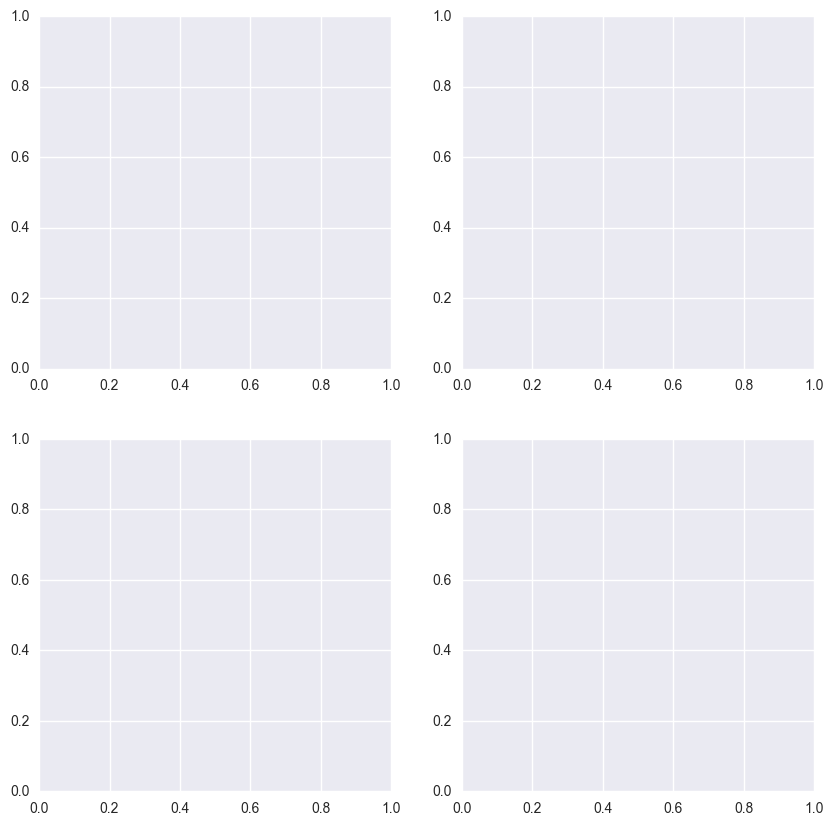

In [8]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from itertools import islice

f, axarr = plt.subplots(2, 2, figsize=(10, 10))
r = np.linspace(0, 1, 10000)

#axarr[0, 0].scatter(x_r, x_r)
#axarr[0, 0].set_title("recursive LCG")

x = list(islice(lcg(0, 135412, 5121, 1712289), 10000))

#axarr[0, 1].scatter(x, x)
#axarr[0, 1].set_title("iterative LCG")

#axarr[1, 0].scatter(x_p, x_p)
#axarr[1, 0].set_title("Python random uniform")

#axarr[1, 1].scatter(x_n, x_n)
#axarr[1, 1].set_title("Numpy random uniform")

plt.show()

In [9]:
def left_shift(x):
    return [0] + x[:-1]

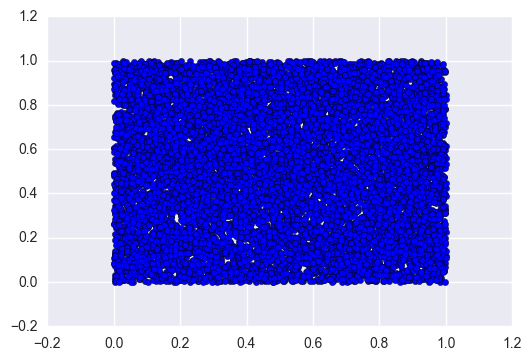

In [10]:
plt.scatter(x, left_shift(x))

# Question 2

Apply different statistical tests to the generator.

We do a Kolmogorov-Smirnov test on the empirical data.

In [11]:
lcg_gen = lcg(0, 135412, 5121, 1712289)
take = lambda f, n: list(islice(f, n))

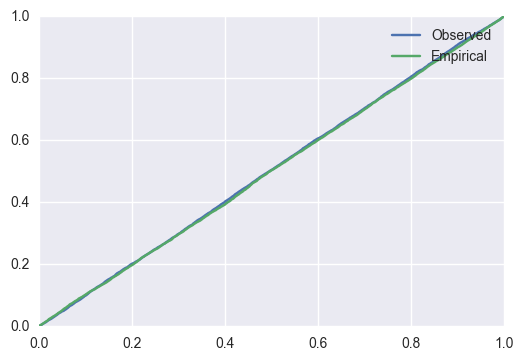

In [12]:
a, = plt.plot(1.0*np.arange(len(x))/(len(x) - 1), np.sort(x))

y = np.random.uniform(0, 1, 10000)
b, = plt.plot(1.0*np.arange(len(y))/(len(y) - 1), np.sort(y))

plt.legend([a, b], ["Observed", "Empirical"])

plt.show()

In [13]:
def ks(x):
    n = m = len(x)
    D = np.max(np.sort(x) - np.sort(np.random.uniform(0, 1, m)))
    c = 1.36 # c(alpha) value for p = 0.05
    value = c * np.sqrt((n+m)/n*m)
    
    # if True then reject
    return D > value

In [14]:
ks(x)

False

In [15]:
from scipy.stats import kstest
kstest(np.random.uniform(0, 1, 10000), 'uniform')

KstestResult(statistic=0.0070871466500884717, pvalue=0.69668312829804102)

We accept the null hypothesis because p > 0.05 therefore, this is a uniform distribution.

# Run tests

In [81]:
def up_down(x):
    n = len(x)
    
    def count_occurences(x):
        inf = 99999999
        y = x.copy() + [-inf]
        n = len(y)

        count = 1
        for i in range(n-1):
            if y[i+1] < y[i]:
                yield count
                count = 0
            count += 1
            
    occurences = list(count_occurences(x))
    
    A = np.array([
              [4529.4, 9044.9, 13568, 18091,  22615,  27892],
              [9044.9, 18097,  27139, 36187,  45234,  55789],
              [13568,  27139,  40721, 54281,  67852,  83685],
              [18091,  36187,  54281, 72414,  90470,  111580],
              [22615,  45234,  67852, 90470,  113262, 139476],
              [27892,  55789,  83685, 111580, 139476, 172860]])

    B = np.array([1/6, 5/24, 11/120, 19/720, 29/5040, 1/840])

    R = [sum(filter(lambda x: x == i, occurences)) for i in range(1, 6)]
    R += [sum(filter(lambda x: x >= 6, occurences))]

    Z = 1/(n - 6) * (R - n*B).T @ A @ (R - n*B)
        
    return R, Z

In [82]:
R, Z = up_down(take(lcg_gen, 10000))

### Chi-square

In [87]:
def chisquare(x, y):
    x = np.sort(x)
    y = np.sort(y)
    return sum((x - y)**2/x)

In [97]:
chisquare(take(lcg_gen, 10000), np.random.uniform(0, 1, 10000))

0.66643600796338531